In [1]:
from importlib import reload
from IPython.display import display
import re
from pprint import pprint
import pickle
from time import time
from joblib import Parallel, delayed
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import sympy
from sympy import simplify

import iota

ar = np.array

# **Dans ce Notebook, on analysera le système simple hyperstatique 2D en utlisant la méthode basée sur une représentation matricielle du mécanisme**

### On doit d'abord définir les différentes matrices de notre chaine.
Avec les classes définies dans ```matrix_construction_assembly```, l'on peut facilement définir nos matrices à partir de quelques informations élémentaires sur notre système. 
Nous avons trois types de matrices de transformations. 

Les matrices T :
 - Elles représentent les transformations internes aux pièces nominales. Pour leur construction, on nécessite un point de départ et d'arrivée, et un repère de départ et d'arrivée. Les repères sont définis dans un repère global. 
 
 

#### **Définition des grandeurs nominales de la pièce**

In [2]:
hM = 10  # hauteur male
hF = 10.2  # hauteur femelle
L1 = 30
L2 = 70
L3 = L1
lM = 10  # largeur male
lF = 10.2  # largeur femelle

#### **Définition du repère global R0 / qui est aussi un repère local de la pièce fixe.**

#### **Définisson les coordonnées des points charactéristiques de chaque surface de chaque pièce.**

In [3]:
# Pièce 1 (male)
P1A0, P1A1, P1A2 = (
    ar((L1 - lM / 2, hM / 2, 0.0)),
    ar((L1 - lM / 2, 0, 0.0)),
    ar((L1 - lM / 2, hM, 0.0)),
)
P1B0, P1B1, P1B2 = (
    ar((L1 + lM / 2, hM / 2, 0.0)),
    ar((L1 + lM / 2, 0, 0.0)),
    ar((L1 + lM / 2, hM, 0.0)),
)
P1C0, P1C1, P1C2 = (
    ar((L1 + L2 - lM / 2, hM / 2, 0.0)),
    ar((L1 + L2 - lM / 2, 0, 0.0)),
    ar((L1 + L2 - lM / 2, hM, 0.0)),
)
P1D0, P1D1, P1D2 = (
    ar((L1 + L2 + lM / 2, hM / 2, 0.0)),
    ar((L1 + L2 + lM / 2, 0, 0.0)),
    ar((L1 + L2 + lM / 2, hM, 0.0)),
)
P1E0, P1E1 = ar((0.0, 0.0, 0.0)), ar((L1 + L2 + L3, 0.0, 0.0))

# Pièce 2 (femelle)  # On met les points à hM et pas hF pour qu'ils soient bien oposées! (Besoin??)
P2A0, P2A1, P2A2 = (
    ar((L1 - lF / 2, hF / 2, 0.0)),
    ar((L1 - lF / 2, 0, 0.0)),
    ar((L1 - lF / 2, hF, 0.0)),
)
P2B0, P2B1, P2B2 = (
    ar((L1 + lF / 2, hF / 2, 0.0)),
    ar((L1 + lF / 2, 0, 0.0)),
    ar((L1 + lF / 2, hF, 0.0)),
)
P2C0, P2C1, P2C2 = (
    ar((L1 + L2 - lF / 2, hF / 2, 0.0)),
    ar((L1 + L2 - lF / 2, 0, 0.0)),
    ar((L1 + L2 - lF / 2, hF, 0.0)),
)
P2D0, P2D1, P2D2 = (
    ar((L1 + L2 + lF / 2, hF / 2, 0.0)),
    ar((L1 + L2 + lF / 2, 0, 0.0)),
    ar((L1 + L2 + lF / 2, hF, 0.0)),
)
P2E0, P2E1 = ar((0.0, 0.0, 0.0)), ar((L1 + L2 + L3, 0.0, 0.0))

#### **Définisson les repères locaux de chaque surface substituée.**

In [4]:
R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

# Pièce1
RP1b = RP1d = R0
RP1a = RP1c = ar([-x_, -y_, z_]).T
RP1e = ar([y_, -x_, z_]).T

# Pièce2
RP2a = RP2c = R0
RP2b = RP2d = ar([-x_, -y_, z_]).T
RP2e = ar([-y_, x_, z_]).T

#### **Maintenant construisons les matrices de transformation pour passer du repère global aux repères locaux (et de définition des matrices de déviation et Jeu! )**
- tfrt : transformation from rotation translation

In [5]:
TP1cC0, TP1cC1, TP1cC2 = (
    iota.tfrt(RP1c, P1C0),
    iota.tfrt(RP1c, P1C1),
    iota.tfrt(RP1c, P1C2),
)
TP1aA0, TP1aA1, TP1aA2 = (
    iota.tfrt(RP1a, P1A0),
    iota.tfrt(RP1a, P1A1),
    iota.tfrt(RP1a, P1A2),
)
TP1bB0, TP1bB1, TP1bB2 = (
    iota.tfrt(RP1b, P1B0),
    iota.tfrt(RP1b, P1B1),
    iota.tfrt(RP1b, P1B2),
)
TP1dD0, TP1dD1, TP1dD2 = (
    iota.tfrt(RP1d, P1D0),
    iota.tfrt(RP1d, P1D1),
    iota.tfrt(RP1d, P1D2),
)
TP1eE0, TP1eE1 = iota.tfrt(RP1e, P1E0), iota.tfrt(RP1e, P1E1)
TP2aA0, TP2aA1, TP2aA2 = (
    iota.tfrt(RP2a, P2A0),
    iota.tfrt(RP2a, P2A1),
    iota.tfrt(RP2a, P2A2),
)
TP2cC0, TP2cC1, TP2cC2 = (
    iota.tfrt(RP2c, P2C0),
    iota.tfrt(RP2c, P2C1),
    iota.tfrt(RP2c, P2C2),
)
TP2bB0, TP2bB1, TP2bB2 = (
    iota.tfrt(RP2b, P2B0),
    iota.tfrt(RP2b, P2B1),
    iota.tfrt(RP2b, P2B2),
)
TP2dD0, TP2dD1, TP2dD2 = (
    iota.tfrt(RP2d, P2D0),
    iota.tfrt(RP2d, P2D1),
    iota.tfrt(RP2d, P2D2),
)
TP2eE0, TP2eE1 = iota.tfrt(RP2e, P2E0), iota.tfrt(RP2e, P2E1)

In [6]:
TMD = {}
TMD["T2e2a"] = iota.TransformationMatrix(initial=TP2eE0, final=TP2aA0)
TMD["T1a1e"] = iota.TransformationMatrix(initial=TP1aA0, final=TP1eE0)
TMD["T2e2d"] = iota.TransformationMatrix(initial=TP2eE0, final=TP2dD0)
TMD["T1d1e"] = iota.TransformationMatrix(initial=TP1dD0, final=TP1eE0)
TMD["T2c2b"] = iota.TransformationMatrix(initial=TP2cC0, final=TP2bB0)
TMD["T1b1c"] = iota.TransformationMatrix(initial=TP1bB0, final=TP1cC0)
TMD["T2b2a"] = iota.TransformationMatrix(initial=TP2bB0, final=TP2aA0)
TMD["T1a1b"] = iota.TransformationMatrix(initial=TP1aA0, final=TP1bB0)

TMD["TP1eE1eE0"] = iota.TransformationMatrix(initial=TP1eE1, final=TP1eE0)
TMD["TP2eE0eE1"] = iota.TransformationMatrix(initial=TP2eE0, final=TP2eE1)

TMD["TP2aA1aA0"] = iota.TransformationMatrix(initial=TP2aA1, final=TP2aA0)
TMD["TP1aA0aA1"] = iota.TransformationMatrix(initial=TP1aA0, final=TP1aA1)
TMD["TP2aA2aA0"] = iota.TransformationMatrix(initial=TP2aA2, final=TP2aA0)
TMD["TP1aA0aA2"] = iota.TransformationMatrix(initial=TP1aA0, final=TP1aA2)

TMD["TP2bB1bB0"] = iota.TransformationMatrix(initial=TP2bB1, final=TP2bB0)
TMD["TP1bB0bB1"] = iota.TransformationMatrix(initial=TP1bB0, final=TP1bB1)
TMD["TP2bB2bB0"] = iota.TransformationMatrix(initial=TP2bB2, final=TP2bB0)
TMD["TP1bB0bB2"] = iota.TransformationMatrix(initial=TP1bB0, final=TP1bB2)

TMD["TP2cC1cC0"] = iota.TransformationMatrix(initial=TP2cC1, final=TP2cC0)
TMD["TP1cC0cC1"] = iota.TransformationMatrix(initial=TP1cC0, final=TP1cC1)
TMD["TP2cC2cC0"] = iota.TransformationMatrix(initial=TP2cC2, final=TP2cC0)
TMD["TP1cC0cC2"] = iota.TransformationMatrix(initial=TP1cC0, final=TP1cC2)

TMD["TP2dD1dD0"] = iota.TransformationMatrix(initial=TP2dD1, final=TP2dD0)
TMD["TP1dD0dD1"] = iota.TransformationMatrix(initial=TP1dD0, final=TP1dD1)
TMD["TP2dD2dD0"] = iota.TransformationMatrix(initial=TP2dD2, final=TP2dD0)
TMD["TP1dD0dD2"] = iota.TransformationMatrix(initial=TP1dD0, final=TP1dD2)

In [7]:
# Deviation matrix with no defects
I4, J4 = iota.I4(), iota.J4()
DI4 = iota.DeviationMatrix(index=-1, translations="", rotations="")  # Pas de défauts

_d",
                      "VARIABLE_G": "u_## **Construisons maintenant les suites de matrices pour calculer les équations de compatibilité**

    - Pour calculer les matrices de transformation entre deux repères locaux, nous devons nous servir des matrices de transformation entre le repère global et les locaux
    - Pour définir les matrices de jeu (gap), il nous faut préciser les degrés de liberté qui sont bloqués.
    - Pour définir les matrices de défaut (deviation), il nous faut préciser les degrés de liberté de du défaut (déduit du type de surface) 
   
En rappel, le schema du modèle 1.5D avec les notations. 
![schema](../SCHEMAS/Juin01/SchemaModele2DMethodeTorseurs.png)

Données longueurs:

    - hM = 10 #hauteur male
    - hF = 10.2 #hauteur femelle
    - L1 = 30 
    - L2 = 70
    - lM = 10 #largeur male
    - lF = 10.2 #largeur femelle


Pour ce système nous avons besoin de 4 "boucles de côtes" LO:
 
    - 1e -> 2e -> 2a -> 1a
    - 1e -> 2e -> 2d -> 1d
    - 1c -> 2c -> 2b -> 1b
    - 1b -> 2b -> 2a -> 1a


Nous allons utiliser une "case" par chaine. 

#### Hypothèses : 

- Le problème est 2D, et la normale globale du problème l'axe Z.
    - Pas de translations hors plan : Tz     = 0 
    - Pas de rotations hors plan :    Rx, Ry = 0
- Il n'y a pas de défauts sur la surface e, et le contact entre les deux pièces parfait.  
- Les erreurs de type plan, dans leur repère local, n'admettent que 3 degrés de liberté (2 en 2D ici): Tx, Rz
- Les jeux entre les surfaces e vont avoir tout les degrés de liberté bloqués, sauf Ty 
- Les jeux entre les surfaces *a*, *b*, *c* et *d* vont avoir tout de bloqués, sauf Tx, Rz

## Définition des matrices de transformation, jeu et défaut et construction des boucles représentant les équations de compatibilité. 

In [8]:
expr_compa_l = []

In [9]:
# Commencons par la boucle 1. Dans la définition du dessus, les jeux et erreurs manquent.
# Boucle 1 : 1e -> 2e -> 2a -> 1a
# Définissons les matrices :
D1e1e = Di2e2e = DI4
GP1eE0P2eE0 = iota.GapMatrix(
    index=0, translations_blocked="zx", rotations_blocked="xyz"
)  ## GAP 0 GP1eE0P2eE0
D2a2a = iota.DeviationMatrix(index=0, translations="x", rotations="z")  # Erreur plan
GP2aA0P1aA0 = iota.GapMatrix(
    index=1, translations_blocked="z", rotations_blocked="xy"
)  ## GAP 1 GP2aA0P1aA0
Di1a1a = iota.DeviationMatrix(index=1, translations="x", rotations="z", inverse=True)

expr_compa_l.append(
    iota.FirstOrderMatrixExpansion(
        [
            D1e1e,
            GP1eE0P2eE0,
            J4,
            Di2e2e,
            TMD["T2e2a"],
            D2a2a,
            GP2aA0P1aA0,
            J4,
            Di1a1a,
            TMD["T1a1e"],
        ]
    ).compute_first_order_expansion()
)
expr_compa_l[0]

Matrix([
[                                1, -gamma_d_0 + gamma_d_1 - gamma_g_1, 0,                      -25*gamma_d_0 + 25*gamma_d_1 - 25*gamma_g_1 + v_g_1 + 1/10],
[gamma_d_0 - gamma_d_1 + gamma_g_1,                                  1, 0, -5*gamma_d_0 + 5*gamma_d_1 - 5*gamma_g_1 - u_d_0 - u_d_1 - u_g_1 + v_g_0 + 1/10],
[                                0,                                  0, 1,                                                                               0],
[                                0,                                  0, 0,                                                                               1]])

In [10]:
# Boucle 2 : 1e -> 2e -> 2d -> 1d
# D1e1e, G1e2e, D2e2e already defined

D2d2d = iota.DeviationMatrix(index=2, translations="x", rotations="z")  # Erreur plan
GP2dD0P1dD0 = iota.GapMatrix(
    index=2, translations_blocked="z", rotations_blocked="xy"
)  ## GAP 2 GP2dD0P1dD0
Di1d1d = iota.DeviationMatrix(index=3, translations="x", rotations="z", inverse=True)

expr_compa_l.append(
    iota.FirstOrderMatrixExpansion(
        [
            D1e1e,
            GP1eE0P2eE0,
            J4,
            Di2e2e,
            TMD["T2e2d"],
            D2d2d,
            GP2dD0P1dD0,
            J4,
            Di1d1d,
            TMD["T1d1e"],
        ]
    ).compute_first_order_expansion()
)
expr_compa_l[1]

Matrix([
[                                1, -gamma_d_2 + gamma_d_3 - gamma_g_2, 0,                   -105*gamma_d_2 + 105*gamma_d_3 - 105*gamma_g_2 - v_g_2 + 1/10],
[gamma_d_2 - gamma_d_3 + gamma_g_2,                                  1, 0, -5*gamma_d_2 + 5*gamma_d_3 - 5*gamma_g_2 + u_d_2 + u_d_3 + u_g_2 + v_g_0 - 1/10],
[                                0,                                  0, 1,                                                                               0],
[                                0,                                  0, 0,                                                                               1]])

In [11]:
# Boucle 3 : 1c -> 2c -> 2b -> 1b
D1c1c = iota.DeviationMatrix(index=4, translations="x", rotations="z")  # Erreur plan
GP1cC0P2cC0 = iota.GapMatrix(
    index=3, translations_blocked="z", rotations_blocked="xy"
)  ### GAP 3 GP1cC0P2cC0
Di2c2c = iota.DeviationMatrix(index=5, translations="x", rotations="z", inverse=True)

D2b2b = iota.DeviationMatrix(index=6, translations="x", rotations="z")  # Erreur plan
GP2bB0P1bB0 = iota.GapMatrix(
    index=4, translations_blocked="z", rotations_blocked="xy"
)  ### GAP 4 GP2bB0P1bB0
Di1b1b = iota.DeviationMatrix(index=7, translations="x", rotations="z", inverse=True)

expr_compa_l.append(
    iota.FirstOrderMatrixExpansion(
        [
            D1c1c,
            GP1cC0P2cC0,
            J4,
            Di2c2c,
            TMD["T2c2b"],
            D2b2b,
            GP2bB0P1bB0,
            J4,
            Di1b1b,
            TMD["T1b1c"],
        ]
    ).compute_first_order_expansion()
)
expr_compa_l[2]

Matrix([
[                                                                    1, -gamma_d_4 + gamma_d_5 - gamma_d_6 + gamma_d_7 - gamma_g_3 - gamma_g_4, 0,                                                   u_d_4 + u_d_5 + u_d_6 + u_d_7 + u_g_3 + u_g_4 - 1/5],
[gamma_d_4 - gamma_d_5 + gamma_d_6 - gamma_d_7 + gamma_g_3 + gamma_g_4,                                                                      1, 0, -gamma_d_4/5 + gamma_d_5/5 - 60*gamma_d_6 + 60*gamma_d_7 - gamma_g_3/5 - 60*gamma_g_4 + v_g_3 + v_g_4],
[                                                                    0,                                                                      0, 1,                                                                                                     0],
[                                                                    0,                                                                      0, 0,                                                                                            

In [12]:
# Boucle 4 : 1b -> 2b -> 2a -> 1a
D1b1b = Di1b1b.get_inverse()
GP1bB0P2bB0 = GP2bB0P1bB0.get_inverse()  # INVERT J4 !!!
Di2b2b = D2b2b.get_inverse()

expr_compa_l.append(
    iota.FirstOrderMatrixExpansion(
        [
            D1b1b,
            J4,
            GP1bB0P2bB0,
            Di2b2b,
            TMD["T2b2a"],
            D2a2a,
            GP2aA0P1aA0,
            J4,
            Di1a1a,
            TMD["T1a1b"],
        ]
    ).compute_first_order_expansion()
)
expr_compa_l[3]

Matrix([
[                                                                    1, -gamma_d_0 + gamma_d_1 + gamma_d_6 - gamma_d_7 - gamma_g_1 + gamma_g_4, 0,                                                  u_d_0 + u_d_1 + u_d_6 + u_d_7 + u_g_1 + u_g_4 - 1/5],
[gamma_d_0 - gamma_d_1 - gamma_d_6 + gamma_d_7 + gamma_g_1 - gamma_g_4,                                                                      1, 0, 10*gamma_d_0 - 10*gamma_d_1 + gamma_d_6/5 - gamma_d_7/5 + 10*gamma_g_1 + gamma_g_4/5 + v_g_1 + v_g_4],
[                                                                    0,                                                                      0, 1,                                                                                                    0],
[                                                                    0,                                                                      0, 0,                                                                                               

In [13]:
compatibility_expressions = [
    x for expr_f in expr_compa_l for x in iota.get_relevant_expressions(expr_f)
]

In [14]:
symbols_deviation, symbols_gap = iota.get_symbols_in_expressions(
    compatibility_expressions
)
print(symbols_deviation)
print(symbols_gap)

[u_d_0, gamma_d_0, u_d_1, gamma_d_1, u_d_2, gamma_d_2, u_d_3, gamma_d_3, u_d_4, gamma_d_4, u_d_5, gamma_d_5, u_d_6, gamma_d_6, u_d_7, gamma_d_7]
[v_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, u_g_3, v_g_3, gamma_g_3, u_g_4, v_g_4, gamma_g_4]


The free symbols we have above are all the free variables from our compatibility expressions. For our system, only the variables with *_g* (representing the play) have to be used. The deviations varialbes (with *_d*) will be fixed. 

For this we will use a function that for a given set of fixed deviations returns us the linear system to resolve. 

## Définition et expression des contraintes d'interface

Pour caractériser la non interpénétration de matière entre deux surfaces, Il nous faut définir des contraintes d'interface.

Ces contraintes d'interface ne vont pas introduire de nouvelles variables, mais résulter de l'expressions des jeux à de nouveaux points. 

Pour l'instant nous travaillons seulement avec des surfaces planes parfaitement alignées.

Une contrainte d'inégalitée entre le jeu définit au nouveau point doit être introduite, signifiant la positivitée du jeu. 

Comme nous sommes en 2D, pour chaque paire de surface en contact nous allons introduire 2 contraintes d'interface. Donc 8 équations au total. 
Pour la surface **a** les nouveaux points sont **A1** et **A2**, pour **b** **B1** et **B2** etc. 

L'idée est de réexprimer le jeu aux points charactéristiques des surfaces, en se basant sur le jeu qui a déja été éxprimé en leur centre pour les équations de compatibilité. Ensuite on applique une contraite de positivité sur certaines composantes de ce vecteur jeu. 

In [15]:
expr_inter_l = []

In [16]:
# C'est le vecteur translation du jeu projeté sur la normale de la surface dont ilest issu qui doit être positif.
# Contrainte d'interface 0 :
# GP2aA1P1aA1 = TP2aA1aA0 J4 GP2aA0P1aA0 TP1aA0aA1 J4 # J1b

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2aA1aA0"], GP2aA0P1aA0, J4, TMD["TP1aA0aA1"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[0][0, 3]

5*gamma_g_1 + u_g_1

In [17]:
# Contrainte d'interface 1 :
# GP2aA2P1aA2 = TP2aA2aA0 J4 GP2aA0P1aA0 TP1aA0aA2 J4 # J1h

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2aA2aA0"], GP2aA0P1aA0, J4, TMD["TP1aA0aA2"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[1][0, 3]

-5*gamma_g_1 + u_g_1

In [18]:
# Contrainte d'interface 2:
# GP2bB1P1bB1 = TP2bB1bB0 J4 GP2bB0P1bB0 TP1bB0bB1 J4  # J2b

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2bB1bB0"], GP2bB0P1bB0, J4, TMD["TP1bB0bB1"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[2][0, 3]

-5*gamma_g_4 + u_g_4

In [19]:
# Contrainte d'interface 3 :
# GP2bB2P1bB2 = TP2bB2bB0 J4 GP2bB0P1bB0 TP1bB0bB2 # J2h

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2bB2bB0"], GP2bB0P1bB0, J4, TMD["TP1bB0bB2"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[3][0, 3]

5*gamma_g_4 + u_g_4

In [20]:
# Contrainte d'interface 4 :
# GP2cC1P1cC1 = TP2cC1cC0 J4 GP2cC0P1cC0 TP1cC0cC1 J4 # J3b
GP2cC0P1cC0 = GP1cC0P2cC0.get_inverse()

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2cC1cC0"], J4, GP2cC0P1cC0, TMD["TP1cC0cC1"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[4][0, 3]

-5*gamma_g_3 + u_g_3

In [21]:
# Contrainte d'interface 4 :
# GP2cC1P1cC1 = TP2cC1cC0 J4 GP2cC0P1cC0 TP1cC0cC1 J4 # J3b

iota.FirstOrderMatrixExpansion(
    [TMD["TP1cC0cC1"].get_inverse(), GP1cC0P2cC0, J4, TMD["TP2cC1cC0"].get_inverse(), J4]
).compute_first_order_expansion()


Matrix([
[        1, -gamma_g_3, 0, -51*gamma_g_3/10 + u_g_3],
[gamma_g_3,          1, 0,             v_g_3 + 1/10],
[        0,          0, 1,                        0],
[        0,          0, 0,                        1]])

In [22]:
TMD["TP2cC1cC0"]

TransformationMatrix with index -1 and values:
Matrix([
[1.0,   0,   0,   0],
[  0, 1.0,   0, 5.1],
[  0,   0, 1.0,   0],
[  0,   0,   0, 1.0]]) and name : 

In [23]:
TMD["TP1cC0cC1"]

TransformationMatrix with index -1 and values:
Matrix([
[1.0,   0,   0,   0],
[  0, 1.0,   0, 5.0],
[  0,   0, 1.0,   0],
[  0,   0,   0, 1.0]]) and name : 

In [24]:
# Contrainte d'interface 5 :
# GP2cC2P1cC2 = TP2cC2cC0 J4 GP2cC0P1cC0 TP1cC0cC2 J4 # J3h

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2cC2cC0"], J4, GP2cC0P1cC0, TMD["TP1cC0cC2"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[5][0, 3]

5*gamma_g_3 + u_g_3

In [25]:
# Contrainte d'interface 6 :
# GP2dD1P1dD1 = TP2dD1dD0 J4 GP2dD0P1dD0 TP1dD0dD1 J4 # J4b

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2dD1dD0"], GP2dD0P1dD0, J4, TMD["TP1dD0dD1"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[6][0, 3]

-5*gamma_g_2 + u_g_2

In [26]:
# Contrainte d'interface 7 :
# GP2dD2P1dD2 = TP2dD2dD0 J4 GP2dD0P1dD0 TP1dD0dD2 J4 # J4h

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP2dD2dD0"], GP2dD0P1dD0, J4, TMD["TP1dD0dD2"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[7][0, 3]

5*gamma_g_2 + u_g_2

In [27]:
# Contrainte d'interface 8 :
# GP1eE1P2eE1 = TP1eE1eE0 J4 GP1eE0P2eE0 TP2eE0eE1 J4

expr_inter_l.append(
    iota.FirstOrderMatrixExpansion(
        [TMD["TP1eE1eE0"], GP1eE0P2eE0, J4, TMD["TP2eE0eE1"], J4]
    ).compute_first_order_expansion()
)
expr_inter_l[8][0, 3]

0

In [28]:
for thing in expr_inter_l:
    display(thing)

Matrix([
[        1, -gamma_g_1, 0, 5*gamma_g_1 + u_g_1],
[gamma_g_1,          1, 0,        v_g_1 + 1/10],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

Matrix([
[        1, -gamma_g_1, 0, -5*gamma_g_1 + u_g_1],
[gamma_g_1,          1, 0,         v_g_1 - 1/10],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

Matrix([
[        1, -gamma_g_4, 0, -5*gamma_g_4 + u_g_4],
[gamma_g_4,          1, 0,         v_g_4 - 1/10],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

Matrix([
[        1, -gamma_g_4, 0, 5*gamma_g_4 + u_g_4],
[gamma_g_4,          1, 0,        v_g_4 + 1/10],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

Matrix([
[         1, gamma_g_3, 0, -5*gamma_g_3 + u_g_3],
[-gamma_g_3,         1, 0,         v_g_3 + 1/10],
[         0,         0, 1,                    0],
[         0,         0, 0,                    1]])

Matrix([
[         1, gamma_g_3, 0, 5*gamma_g_3 + u_g_3],
[-gamma_g_3,         1, 0,        v_g_3 - 1/10],
[         0,         0, 1,                   0],
[         0,         0, 0,                   1]])

Matrix([
[        1, -gamma_g_2, 0, -5*gamma_g_2 + u_g_2],
[gamma_g_2,          1, 0,         v_g_2 - 1/10],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

Matrix([
[        1, -gamma_g_2, 0, 5*gamma_g_2 + u_g_2],
[gamma_g_2,          1, 0,        v_g_2 + 1/10],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

Matrix([
[1, 0, 0,     0],
[0, 1, 0, v_g_0],
[0, 0, 1,     0],
[0, 0, 0,     1]])

Maintenant que nous avons toutes les expressions des Contrainte d'interface sous forme de matrice de transformation, nous avons plus qu'a garder ce qui nous intéresse, c'ezst à dire la composante de translation selon x (la meme pour tous les jeux). 

In [29]:
mask_matrix = sympy.Matrix(
    np.array([[0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
)
expr_inter_l = [expa_f.multiply_elementwise(mask_matrix) for expa_f in expr_inter_l]
interface_constraints = [
    x for expr_f in expr_inter_l for x in iota.get_relevant_expressions(expr_f)
]

In [30]:
print("### Compatibility equations : ###")
for i in range(len(compatibility_expressions)):
    display(simplify(compatibility_expressions[i]))

print("\n### Interface equations : ###")
for i in range(len(interface_constraints)):
    display(interface_constraints[i])

### Compatibility equations : ###


-gamma_d_0 + gamma_d_1 - gamma_g_1

-25*gamma_d_0 + 25*gamma_d_1 - 25*gamma_g_1 + v_g_1 + 1/10

-5*gamma_d_0 + 5*gamma_d_1 - 5*gamma_g_1 - u_d_0 - u_d_1 - u_g_1 + v_g_0 + 1/10

-gamma_d_2 + gamma_d_3 - gamma_g_2

-105*gamma_d_2 + 105*gamma_d_3 - 105*gamma_g_2 - v_g_2 + 1/10

-5*gamma_d_2 + 5*gamma_d_3 - 5*gamma_g_2 + u_d_2 + u_d_3 + u_g_2 + v_g_0 - 1/10

-gamma_d_4 + gamma_d_5 - gamma_d_6 + gamma_d_7 - gamma_g_3 - gamma_g_4

u_d_4 + u_d_5 + u_d_6 + u_d_7 + u_g_3 + u_g_4 - 1/5

-gamma_d_4/5 + gamma_d_5/5 - 60*gamma_d_6 + 60*gamma_d_7 - gamma_g_3/5 - 60*gamma_g_4 + v_g_3 + v_g_4

-gamma_d_0 + gamma_d_1 + gamma_d_6 - gamma_d_7 - gamma_g_1 + gamma_g_4

u_d_0 + u_d_1 + u_d_6 + u_d_7 + u_g_1 + u_g_4 - 1/5

10*gamma_d_0 - 10*gamma_d_1 + gamma_d_6/5 - gamma_d_7/5 + 10*gamma_g_1 + gamma_g_4/5 + v_g_1 + v_g_4


### Interface equations : ###


5*gamma_g_1 + u_g_1

-5*gamma_g_1 + u_g_1

-5*gamma_g_4 + u_g_4

5*gamma_g_4 + u_g_4

-5*gamma_g_3 + u_g_3

5*gamma_g_3 + u_g_3

-5*gamma_g_2 + u_g_2

5*gamma_g_2 + u_g_2

## Construction du système d'équations linéaires


Maintenant que nous avons les équations de compatibilité et les contraintes d'interface, nous devons créer une fonction qui, a partir d'un ensemble de défauts fixés nous renvoie un système sympy à résoudre. Plus exactement, il devra nous rennoyer les différentes matrices qui serviroint à initialiser le système. 


L'on peut essayer de créer une fonction qui prend en entrée les équations de compatibilité et fonctionelles, et nous renvoie une fonction qui peut prendre les défauts en entrée et qui renvoie les matrices du système.

In [31]:
SOCAM = iota.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints
)

with open("tamp_2_D.pkl", "wb") as outp:
    pickle.dump(SOCAM, outp, pickle.HIGHEST_PROTOCOL)

# Estimation de la probabilité de défaillance par Monte-Carlo

Les codes permettant de simuler le système mécanique ayant été définis, nous allons valider leur fonctionalité en éffectuant une étude similaire au notebook "Analyse_Preli_Trou_Carre_2D", et en comparant les résultats. 

Commencons d'abord en définissant les tolérances et en calculant leur effet sur la variance des différents défauts élémentaires. 

Ensuite nous pourrons créer le plan d'experience, en y introduisant aussi l'imprécision par l'intermédaire d'un coefficient d'allocation du défaut. 

In [32]:
# Tiré du notebook "ReferenceParameterization"
tol = 0.1

Cm = 0.3  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
# The values for the stds is choosen in case where only one defect is present
sigma_e_pos = tol / (6 * Cm)

theta_max = tol / hM
sigma_e_theta = (2 * theta_max) / (6 * Cm)

SIZE_MC = int(1e3)  # Size of the DOE (Design of experiment)

To drive the monte carlo simulation, it would be easier to have a generator object that can produce deviations in s controllable manner. 
For this effect, the openTURNS library offers probabilistic tools useful for our task. 

The informations we need to construct this model are :
 - The deviation parameter names and types (rotation/translation...)
 - The maximal standard deviation of each elementary defect taken separatly
 - The allocation of the defect between the deviations of a same feature. 

We'll add some more methods to the deviation fixer class, to be able to set the standard deviations of each parameter. 

Then we'll add an other method which will take as an input a set of lambda variables and return the generator object. The difficulty here is that the number of lambdas depends on the degrees of freedom of the feature. For N DOF there are N lambda parameters (even if in pract-ice only N-1 are necessary) The lambdas are positive and their sum equals to 1.

As for each variable in iota.deviation_symbols, the index defining it garanties that it belongs to only one feature. So by counting the number of variables with the same integers we can set our lambdas. Also the index links the variable to the feature (and its characteristics)

For now we'll make some bold assumptions. Cause there is no time to formalize/generalize it further. 
First of all, all surfaces have the same defects for the respective DOF. That's enough for now, the lambdas will be generated through an LHS. 

In [33]:
RandDeviationVect = iota.get_composed_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_e_theta=sigma_e_theta,
    sigma_e_pos=sigma_e_pos,
)

Now we have a function that can generate defects in the range authorized by the deviation domains (if each DOF would be taken individually). We now need to introduce a new step to control the imprecision, or rather the allocations between the degrees of freedom of the defects. As in this case for each feature we only have 2 DOF, we need one parameter per feature to control the allocation.
We have 8 features with defects, and 2 degrees of freedom per feature, so we will need 16 parameters. 

Our first approach for generating the lambdas will have 2 steps, and be the following:

- We first generate a sample following a LHS sampling scheme.Each parameter followinf an uniform law between 0 and 1. 

- Then for each set of parameters belonging to the same feature, we set the value of one parameter as the ratio between its value and the sum of all variables belonging to the same feature

In [34]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(SOCAM.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, SOCAM.deviation_symbols)))

ot.RandomGenerator.SetSeed(999)
N_lambda = 200
lambda_sample_unconditioned_generator = ot.LHSExperiment(
    lambda_vect_unconditioned, N_lambda
)
lambda_sample_unconditioned_generator.setAlwaysShuffle(False)  # randomized
# Defining space fillings
spaceFilling = ot.SpaceFillingC2()
# Geometric profile
geomProfile = ot.GeometricProfile(1.0, 0.95573, 2000)
# Simulated Annealing LHS with geometric temperature profile, C2 optimization
optimalLHSAlgorithm = ot.SimulatedAnnealingLHS(
    lambda_sample_unconditioned_generator, spaceFilling, geomProfile
)

lambda_sample_unconditioned = optimalLHSAlgorithm.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = iota.condition_lambda_sample(lambda_sample_random)
print(", ".join(map(str, SOCAM.gap_symbols)))

v_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, u_g_3, v_g_3, gamma_g_3, u_g_4, v_g_4, gamma_g_4


Each point of this sample represents a different configuration of defects where the individual influence of DOF for a feauture has a different effect. For each one of these points, we generate a random monte carlo sample for the defects, multiply it with the lambdas, and then solve the optimization problem for each point in the Monte Carlo DOE to get the probability of non assembly.

In [35]:
C_opt = None  # np.array([1,0,0,1,0,0,0,0,0,0,0,0,0,0,0])
bounds = None  # np.array([[0, 0], [-2, 2], [-0, 0], [0, 2], [-2, 2], [-np.pi, np.pi], [0, 2], [-2, 2], [-np.pi, np.pi], [0, 2], [-2, 2], [-np.pi, np.pi], [0, 2], [-2, 2], [-np.pi, np.pi]])
SEED_MC_PF = 6436431
SIZE_MC_PF = int(1e4)  # Size of the DOE (Design of experiment)

In [36]:
def parallel_function(lambda_sample, SIZE_MC_PF, SEED_MC_PF, SOCAM, C_opt, bounds):
    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * np.array(
        lambda_sample
    )
    return iota.compute_adaptive_failure_probability(
        SOCAM,
        deviation_samples,
        C=C_opt,
        bounds=bounds,
        epsilon_pf=0.004,
        epsilon_std=0.003,
        verbose=0,
    )


if __name__ == "__main__":
    start_time = time()  # Record the start time
    results = np.array(
        Parallel(n_jobs=-2)(
            delayed(parallel_function)(
                lambda_sample_conditioned[i],
                SIZE_MC_PF,
                SEED_MC_PF,
                SOCAM,
                C_opt,
                bounds,
            )
            for i in range(len(lambda_sample_conditioned))
        ),
        dtype=float,
    )

    print(f"Done {len(lambda_sample_conditioned)} experiments.")
    print(f"Elapsed time: {time() - start_time:.3f} seconds.")

Done 200 experiments.
Elapsed time: 51.565 seconds.


In [37]:
print("Lower probability of failure:", round(min(results) * 100, 4), "%")
print("Upper probability of failure:", round(max(results) * 100, 4), "%")

Lower probability of failure: 6.6253 %
Upper probability of failure: 20.8054 %


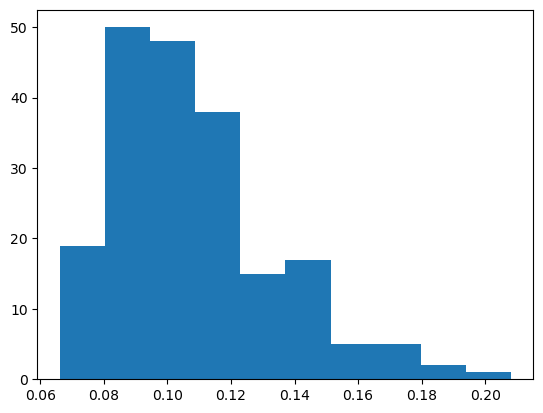

In [38]:
plt.hist(results)
plt.show()